In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import json
from collections import defaultdict

In [ ]:


def reformat_json():
    new_data = defaultdict(dict)
    with open('timeseries.json', 'r') as f:
        data = json.load(f)
        for medicine in data:
            for key in data[medicine]:
                for date in data[medicine][key]:
                    new_data[medicine][date[:10]] = data[medicine][key][date]
    return new_data

databases = {}
def convert_dataframe():
    data = reformat_json()
    for medicine in data:
        databases[medicine] = pd.DataFrame(data[medicine].items(), columns=['date', 'value'])
    return databases
databases = convert_dataframe()
print(databases)

In [ ]:
db1 = defaultdict(dict)
df = pd.read_csv('output.csv')
for i, row in df.iterrows():
    db1[row['medicine']].update({row['date']: row['score']})

for key in db1:
    db1[key] = pd.DataFrame(db1[key].items(), columns=['date', 'score'])
db1 = dict(db1)
print(db1)

In [ ]:
# merge the dataframes in each medicine key with the common date column
for medicine in databases:
    try:
        databases[medicine] = pd.merge(databases[medicine], db1[medicine], on='date', how='left', suffixes=('_1', '_2'))
    except Exception:
        pass

In [ ]:
for medicine in databases:
    databases[medicine]['date'] = pd.to_datetime(databases[medicine]['date'])
    databases[medicine]['year'] = databases[medicine]['date'].dt.year
    databases[medicine]['month'] = databases[medicine]['date'].dt.month
    databases[medicine]['day'] = databases[medicine]['date'].dt.day

In [ ]:
# change based on the medicine you want to predict
databases[medicine] = databases[medicine].dropna()  # drop rows with missing values
X_train, X_test, y_train, y_test = train_test_split(databases[medicine][['year', 'month', 'day', 'score']].values, databases[medicine]['value'].values, test_size=0.2, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
class Availability(nn.Module):
    def __init__(self):
        super(Availability, self).__init__()
        self.fc3 = nn.Linear(4, 64)
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 1)
    def forward(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class Availability(nn.Module):
    def __init__(self):
        super(Availability, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train(medicine):
    databases[medicine] = databases[medicine].dropna()  # drop rows with missing values
    X_train, X_test, y_train, y_test = train_test_split(databases[medicine][['year', 'month', 'day', 'score']].values, databases[medicine]['value'].values, test_size=0.2, shuffle=False)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    model = Availability()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = nn.MSELoss()
    epochs = 75

    for i in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        # print(f'Epoch {i + 1}/{epochs}, Loss: {loss.item()}')
    
    # with torch.no_grad():
    #     for i in range(len(X_test)):
    #         pred = model(X_test[i, :].reshape(1, 1, 4))
    #         # print(f'Prediction: {pred.item()}, Actual: {y_test[i]}')
    try:
        torch.save(model.state_dict(), f'models_new\{medicine}.pth')
    except Exception:   
        pass
    

In [ ]:
for medicine in db1:
    train(medicine)

In [ ]:
model = Availability()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()
epochs = 100

In [ ]:
for i in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {i + 1}/{epochs}, Loss: {loss.item()}')

In [ ]:
import os

In [ ]:
(X_test[1, :].reshape(1, 1, 4))

In [111]:

folder_path = "models_new"
models_list = []

# Initialize model
model = Availability()

# Set model to evaluation mode
model.eval()


# Iterate over each file in the directory
for file_name in os.listdir(folder_path):
    # Check if the file is a .pth file
    name = file_name.replace('.pth', '')
    databases[name] = databases[name].dropna()  # drop rows with missing values
    X_train, X_test, y_train, y_test = train_test_split(databases[name][['year', 'month', 'day', 'score']].values, databases[name]['value'].values, test_size=0.2, shuffle=False)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    if file_name.endswith(".pth"):
        not_good_model = False
        # Get the full path of the file
        file_path = os.path.join(folder_path, file_name)
        
        # Load the model from the .pth file
        model.load_state_dict(torch.load(file_path))
        
        # Pass a batch of data through the model to initialize batch normalization statistics
        with torch.no_grad():
            # Assuming X_test is a tensor of shape (num_samples, 4)
            preds = model(X_test)
        
        # Perform inference and check if the model meets your criteria
        with torch.no_grad():
            for i in range(len(X_test)):
                pred = model(X_test[i, :].reshape(1, 4))  # Assuming input shape is (1, 4)
                if pred.item() > y_test[i] * 1.1 or pred.item() < y_test[i] * 0.9:
                    not_good_model = True
                    break
        
        if not not_good_model:
            models_list.append(file_name)


In [112]:
models_list

['Ivermectin Medical Valley.pth', 'Metomylan.pth']

In [104]:
folder_path = "models_new"
file_name = models_list[3]
file_path = os.path.join(folder_path, file_name)
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [107]:
file_path

'models_new\\Zonegran.pth'

In [105]:
with torch.no_grad():
    for i in range(len(X_test)):
        pred = model(X_test[i, :].reshape(1, 4))
        print(f'Prediction: {pred.item()}, Actual: {y_test[i]}')

Prediction: 2.123537302017212, Actual: 2.180000066757202
Prediction: 2.441741466522217, Actual: 2.200000047683716
Prediction: 2.353288412094116, Actual: 2.319999933242798
Prediction: 2.3855907917022705, Actual: 2.369999885559082


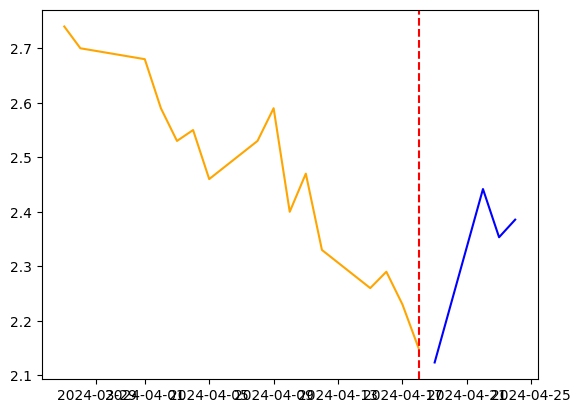

In [106]:
# plt.plot(databases[medicine].loc[:15, 'date'], model(X_train).detach().numpy(), label='Train', color='blue')
plt.plot(databases[medicine].loc[:15, 'date'],  y_train.detach().numpy(), label='Train', color='orange')
plt.plot(databases[medicine].loc[16:, 'date'], model(X_test).detach().numpy(), label='Test', color='blue')
plt.axvline(x=databases[medicine].loc[15, 'date'], color='red', linestyle='--')
# plt.plot(databases[medicine].loc[16:, 'date'], y_test.detach().numpy(), label='Test', color='orange')

In [ ]:
from pprint import pprint
pprint(databases['A-Pen'].head())

In [ ]:
X_train